In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx

import numpy as np
import time

from history import History
from optimisers import train_step, resample_rad, AggressiveLM, PlateauLM

import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson10D
problem = Poisson10D()

In [3]:
xs = np.random.rand(10)

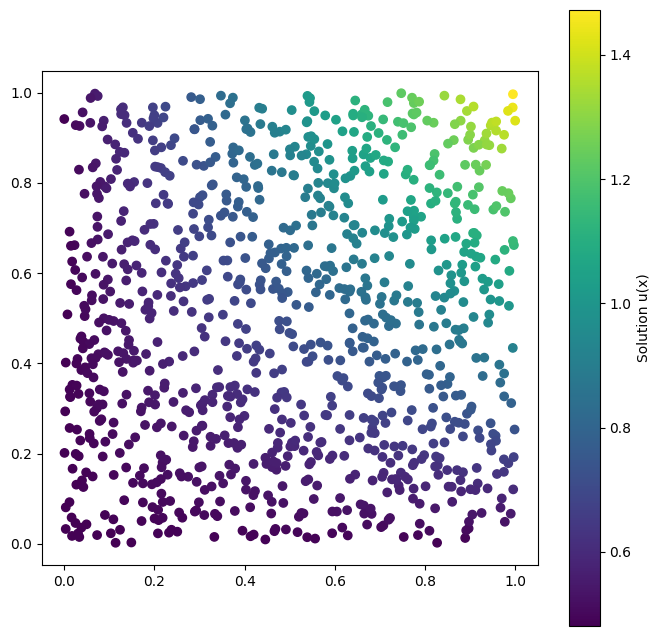

In [4]:
x, y = np.random.rand(2, 1000)
colors = [] # 1. Create a list to store the color values

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

for i in range(1000):
    test_xs = xs.copy()
    test_xs[0] = x[i]
    test_xs[1] = y[i]
    
    u = problem.exact_solution_point(test_xs)
    colors.append(u) # 2. Append the calculated value to the list

# 3. Call scatter ONCE with all the data
scatter = ax.scatter(x, y, c=colors)

# Optional: Add a color bar to understand the values
fig.colorbar(scatter, ax=ax, label="Solution u(x)")

plt.show()

In [5]:
key = jax.random.PRNGKey(42)

layer_sizes = [10, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
model = eqx.combine(params, static) 

# --- Collocation points ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 1.0
n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)
collocation_points = resample_rad(
    model,
    candidate_points,
    n_collocation_points,
    problem,
    rad_k,
    rad_c,
    sample_key
)

optimiser = AggressiveLM(
    init_lambda=1e6,
    increase_factor=1.05,
    max_increase=2.0,
    optimism_factor=0.9,
    decrease_factor=0.9,
)
final_optimiser = PlateauLM(
    increase_factor=1.01,
    decrease_factor=0.9,
    max_increase=1.25,
    plateau_factor=1.01,
)
opt_state = optimiser.init(params)

history = History()


<function matplotlib.pyplot.show(close=None, block=None)>

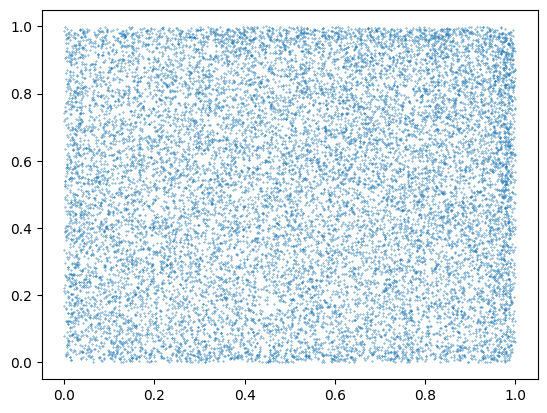

In [12]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [15]:
epoch = 0
total_train_step_time = 0

In [57]:
test_points = problem.get_candidate_points(10000, seed=1)
u_solution = problem.exact_solution_batch(test_points)

In [58]:
print(test_points.shape)
print(u_solution.shape)

print(u_solution[:20])
# print(u_pred[:20])


(10000, 10)
(10000,)
[1.0474005  0.72504866 1.2808502  1.4422609  0.95704335 1.8146869
 1.5281535  0.7990129  0.9720365  1.5313993  0.9322789  1.4907877
 1.324173   0.88306653 1.0524468  1.1235669  0.78254133 1.3799874
 1.0096097  0.77279896]


In [59]:
for _ in range(300):
    
    # Resample
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        model = eqx.combine(params, static) 
        
        sample_key, subkey = jax.random.split(sample_key, 2)
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )

    # Train
    start_train_step_time = time.monotonic()
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)
        
    # Print and record
    model = eqx.combine(params, static)
    u_pred = model.predict(test_points)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

    metrics["rell2error"] = rel_l2_error
    metrics["time"] = total_train_step_time
        
    history.record(metrics)

    if epoch % (resample_every_n_epochs // 2) == 0:
        print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}")
        print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")


Epoch 700, Loss: 2.250e-03
1.915e-05 502.271
Epoch 725, Loss: 1.968e-03
1.986e-05 518.471


KeyboardInterrupt: 

In [21]:
for _ in range(200):
    
    # Resample
    # if epoch % resample_every_n_epochs == 0 and epoch > 0:
    #     model = eqx.combine(params, static) 
        
    #     sample_key, subkey = jax.random.split(sample_key, 2)
    #     collocation_points = resample_rad(
    #         model, 
    #         candidate_points, 
    #         n_collocation_points, 
    #         problem,
    #         rad_k,
    #         rad_c,
    #         subkey
    #     )

    # Train
    start_train_step_time = time.monotonic()
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, final_optimiser, problem, collocation_points
    )
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)
        
    # Print and record
    model = eqx.combine(params, static)
    u_pred = model.predict(test_points)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

    metrics["rell2error"] = rel_l2_error
    metrics["time"] = total_train_step_time
        
    history.record(metrics)

    if epoch % (resample_every_n_epochs // 2) == 0:
        print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}")
        print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")


Epoch 500, Loss: 1.246e-03
2.003e-05 367.343
Epoch 525, Loss: 1.338e-03
2.012e-05 385.245
Epoch 550, Loss: 1.210e-03
1.951e-05 402.240
Epoch 575, Loss: 1.216e-03
1.980e-05 419.186
Epoch 600, Loss: 1.209e-03
1.933e-05 436.494
Epoch 625, Loss: 1.215e-03
1.943e-05 452.872
Epoch 650, Loss: 1.208e-03
1.950e-05 469.145
Epoch 675, Loss: 1.210e-03
1.960e-05 484.843
Training complete.


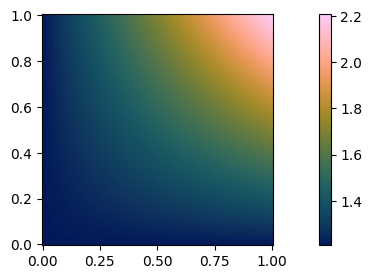

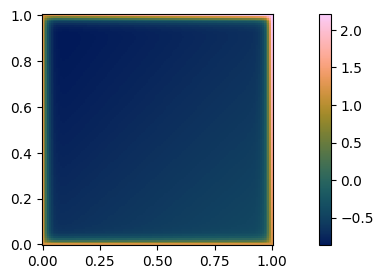

Relative L2 Error: 1.380e+00


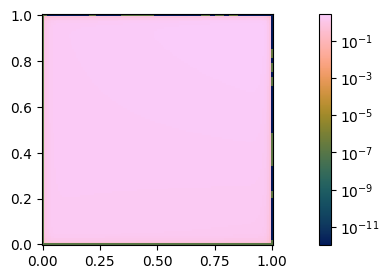

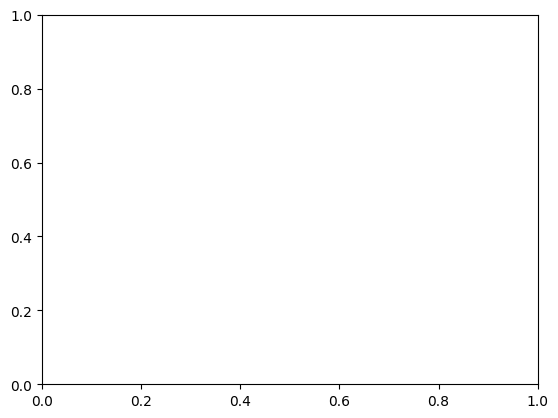

In [6]:
x, y = np.random.rand(2, 1000)

colors = [] # 1. Create a list to store the color values

X, Y = np.meshgrid(np.linspace(0, 1, 128), np.linspace(0, 1, 128))

xs = [0.0, 0.0, 0.64, 0.39, 0.80, 0.85, 0.52, 0.10, 0.48, 0.47]

@np.vectorize()
def get_u(x, y):
    test_xs = xs.copy()
    test_xs[0] = x
    test_xs[1] = y
    u = problem.exact_solution_point(test_xs)
    return u

U = get_u(X, Y)

inputs = np.tile(xs, (128*128, 1))
inputs[:, 0] = X.flatten()
inputs[:, 1] = Y.flatten()
predictions = model.predict(jnp.array(inputs))
U_pred = predictions.reshape(X.shape)


fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, Y, U, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, Y, U_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()


error = np.abs(U - U_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(U)
print(f"Relative L2 Error: {rel_l2_error:.3e}")


norm = mplcolors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, Y, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

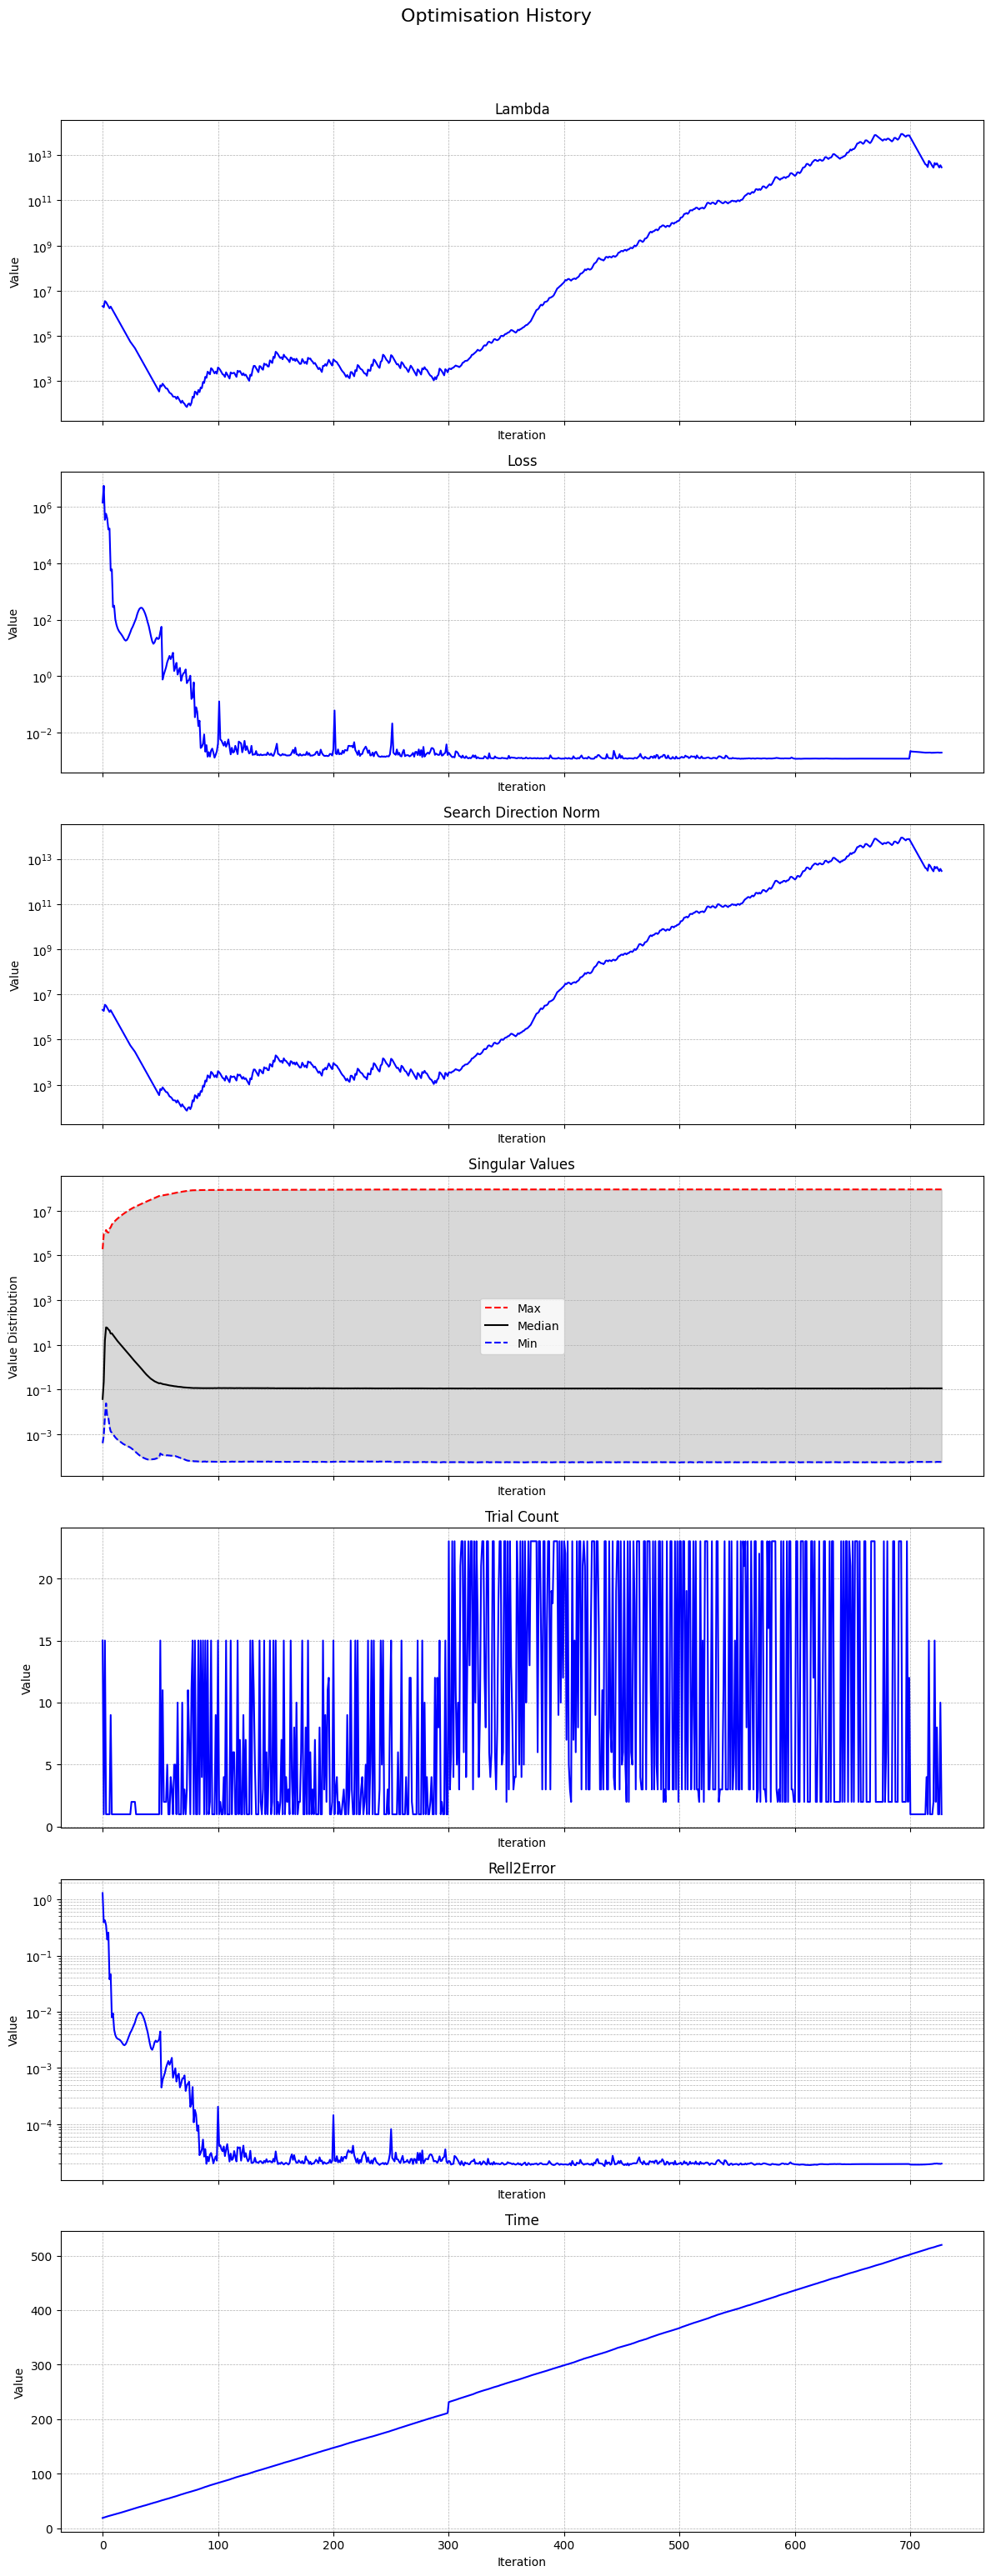

In [60]:
history.plot()

In [61]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [8]:
folder="experiments/10d-poisson/results"

In [10]:
np.save(folder+'/lm_u_pred_start.npy',            U_pred)

In [ ]:
lm_l2err = history.history["rell2error"][:600]
lm_loss = history.history["loss"][:600]
lm_lambda = history.history["lambda"][:600]
lm_searchdirnorm = history.history["search_direction_norm"][:600]
lm_svs = history.history["singular_values"][:600]
lm_time = history.history["time"][:600]

np.save(folder+'/lm_time.npy',              lm_time)
np.save(folder+'/lm_l2err.npy',             lm_l2err)
np.save(folder+'/lm_loss.npy',              lm_loss)
np.save(folder+'/lm_lambda.npy',            lm_lambda)
np.save(folder+'/lm_searchdirnorm.npy',     lm_searchdirnorm)
np.save(folder+'/lm_svs.npy',               lm_svs)
np.save(folder+'/lm_u_pred.npy',            u_pred)
np.save(folder+'/lm_u_solution.npy',        u_solution)
# np.save('lm_X.npy',                 X)
# np.save('lm_T.npy',                 T)


In [ ]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

0.10332031662355522
0.702316730148486


<function matplotlib.pyplot.show(close=None, block=None)>

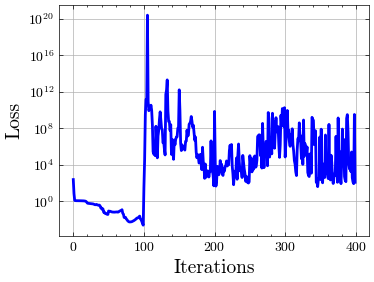

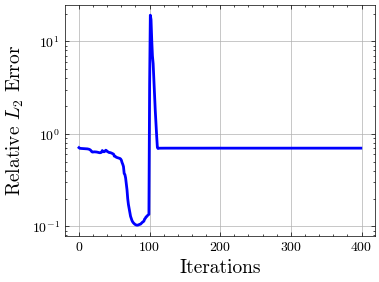

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

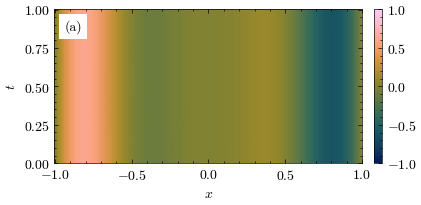

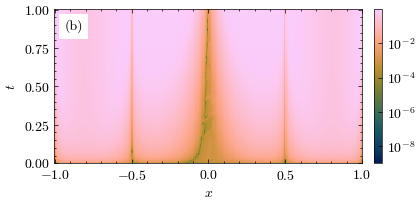

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()